# Analyse the clustering results coming from the gridsearch

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Import packages

In [2]:
from tqdm import tqdm

import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

# Only used on first run
from distributed import Client
import dask.dataframe as dd

pd.options.display.width = 100

### Define functions used mutliple times

In [3]:
# Function to plot the performance of the four clustering algorithms against the number of clusters
def cluster_plot_bokeh(grid):
    # Different dash syles and colors for in the plot
    line_dash = ['solid', 'dashed', 'dotted', 'dotdash']
    color = ['blue', 'red', 'hotpink', 'green']
    # Define the two figures that are going to be made. 1 for the correlation and 2 for the euclidian score.
    p = figure(width=1400, height=500, x_axis_label='Number clusters', y_axis_label='Correlation silhouette score')
    p1 = figure(width=1400, height=500, x_axis_label='Number clusters', y_axis_label='Euclidian silhouette score')
    # Plot every algorithm in there own line
    for i, alg in enumerate(grid):
        df = grid[alg].groupby(['n_clusters']).max().reset_index()
        df = df.sort_values('n_clusters')
        source = ColumnDataSource(df)
        p.line('n_clusters', 'silhouette_score_correlation', source=source,
                    legend_label=f'silhouette score {alg}', color=color[i])
        p1.line('n_clusters', 'silhouette_score_euclidean', source=source,
                    legend_label=f'silhouette score {alg}', color=color[i])
    # Add legend
    p.add_layout(p.legend[0], 'right')
    p.legend.click_policy="hide"
    p1.add_layout(p1.legend[0], 'right')
    p1.legend.click_policy="hide"
    return column(p, p1)

In [4]:
# Print the best scores from mthe gridsearch
def get_individual_score(grid, i):
    top_df = []
    # Loop over every algorithm
    for alg in grid:
        print(f'_________________________________________{alg}_________________________________________')
        print()
        # Some old scores used. Not in all algorithm, remove them if they are still here
        df = grid[alg].copy()
        if 'silhouette_score_manhattan' in df.columns:
            df = df.drop('silhouette_score_manhattan', axis=1)
        if 'calinski_harabasz_score' in df.columns:
            df = df.drop('calinski_harabasz_score', axis=1)
        if 'Fit_Time' in df.columns:
            df = df.drop('Fit_Time', axis=1)
        # Mean of the correlation and euclidian score
        print(f'                        -----------------mean------------------')
        value1 = MinMaxScaler().fit_transform(df['silhouette_score_correlation'].values.reshape(-1, 1))
        value2 = MinMaxScaler().fit_transform(df['silhouette_score_euclidean'].values.reshape(-1, 1))
        df['mean'] = (value1 + value2) / 2
        df = df.sort_values(by='mean', ascending=False)
        df = df.drop('mean', axis=1)
        # Print the top 3 scores
        print(df.head(3))
        print()
        top_df.append([alg, df['silhouette_score_correlation'].values[0], df['silhouette_score_euclidean'].values[0]])
    # Load the results of the baseline
    with open(f'/home/g0017139/UMCG_Thesis/Scripts/Results/TSet{i}/baseline_df.pkl', 'rb') as f:
        baseline = pickle.load(f)
    # Get the top scores of the baseline and add them
    top_df.append(['Baseline', baseline['silhouette_score_correlation'].values[0], 
                   baseline['silhouette_score_euclidean'].values[0]])
    # Print the best scores of everyting
    print('_________________________________________BEST_________________________________________')
    top_df = pd.DataFrame.from_records(top_df, columns=['Algorithm', 'silhouette_score_correlation', 
                                                      'silhouette_score_euclidean'])
    print(top_df)
    names = {
        1: 'CCLE',
        2: 'GPL570',
        4: 'TCGA'
    }
    top_df['Set'] = names[i]
    return top_df

In [5]:
# Same as the bokeh plot but in seaborn
def get_results_plot(grid, i, end=15):
    # Put every algorithm score in the dataframe
    plot_df = pd.DataFrame()
    for alg in grid:
        # Only keep the max score
        df = grid[alg].groupby(['n_clusters']).max().reset_index()
        df = df.sort_values('n_clusters')[['n_clusters','silhouette_score_euclidean', 'silhouette_score_correlation']]
        df['algorithm'] = alg
        plot_df = pd.concat([plot_df, df], ignore_index=True)
    plot_df = plot_df.dropna()
    # Add the baselilne
    with open(f'/home/g0017139/UMCG_Thesis/Scripts/Results/TSet{i}/baseline_df.pkl', 'rb') as f:
        df = pickle.load(f) 
    # Start making the plot
    plot_df = pd.concat([plot_df, df], ignore_index=True)
    fig, axs = plt.subplots(2,1,  figsize=(20,10), sharex=True)
    axs[0].set_xlim(2, end)
    axs[1].set_xlim(2, end)
    g = sns.lineplot(data=plot_df, x='n_clusters', y='silhouette_score_euclidean', hue='algorithm', ax=axs[0])
    g1 = sns.lineplot(data=plot_df, x='n_clusters', y='silhouette_score_correlation', hue='algorithm', ax=axs[1], legend=False)
    fig.suptitle(f'Set {i}', fontsize=24)
    plt.show()
    return plot_df

### Clean and scale GPL570 and save it as a parquet file this severly cuts down on load time

In [6]:
# Make set 2
CLEAN = False
if CLEAN:
    # Use dask to use mutliple threads
    client = Client(threads_per_worker=10)
    GPL570 = dd.read_csv("/data/g0017139/Set2/GPL570__Affy_hgu133plus2_NoDuplicatesamples_CleanedIdentifiers_RMA-sketch_NormalAndCancer_QCed.txt",
        sep='\t', header=0)
    Mapping = pd.read_csv("/data/g0017139/Set2/Genomic_Mapping_hgu133plus2_using_jetscore_30032018.txt",
        sep='\t', header=0)
    Mapping = Mapping[Mapping['top_probe_indicator'] == 1]
    Probe_to_entID = pd.Series(Mapping['ENTREZID'].values,index=Mapping['PROBESET']).to_dict()
    GPL570 = GPL570[GPL570['Unnamed: 0'].isin(Mapping['PROBESET'])]
    GPL570 = GPL570.compute()
    GPL570 = GPL570.set_index('Unnamed: 0')
    GPL570 = GPL570.T
    GPL570.columns = [Probe_to_entID[x] for x in GPL570.columns]
    GPL570.to_csv("/data/g0017139/GPL570_clean.dat", sep = " ")
    GPL570.to_parquet("/data/g0017139/GPL570_clean.parquet")
    # Scale GPL570
    scaler = StandardScaler()
    normalized_set2 = scaler.fit_transform(GPL570)
    normalized_set2 = pd.DataFrame(normalized_set2)
    normalized_set2.columns = [str(x) for x in normalized_set2.columns]
    normalized_set2.to_csv("/data/g0017139/GPL570_norm.dat", sep = " ",header=False, index=False)
    normalized_set2.to_parquet('/data/g0017139/GPL570_norm.parquet')

### Clean and scale TCGA and save it as a parquet file this severly cuts down on load time

In [7]:
if CLEAN:
    # Load it in
    TCGA = pd.read_csv('/data/g0017139/Set2/TCGA__RSEM_genes_RNAseq__duplicate_samples_removed__genes_with_all_zeroes_removed.txt',
                                   sep=None, engine='python', header=0,
    )
    TCGA = TCGA.T
    # Save it as parquet to make it faster for later
    TCGA.columns = [str(x) for x in TCGA.columns]
    TCGA.to_parquet("/data/g0017139/TCGA__RSEM.parquet")
    # Scale it
    scaler = StandardScaler()
    TCGA_norm = scaler.fit_transform(TCGA)
    TCGA_norm = pd.DataFrame(TCGA_norm)
    TCGA_norm.columns = [str(x) for x in TCGA_norm.columns]
    TCGA_norm.to_csv("/data/g0017139/TCGA__RSEM_norm.dat", sep = " ",header=False, index=False)
    TCGA_norm.to_parquet('/data/g0017139/TCGA__RSEM_norm.parquet')

# The results of the gridsearch on CCLE

### Tested parameters

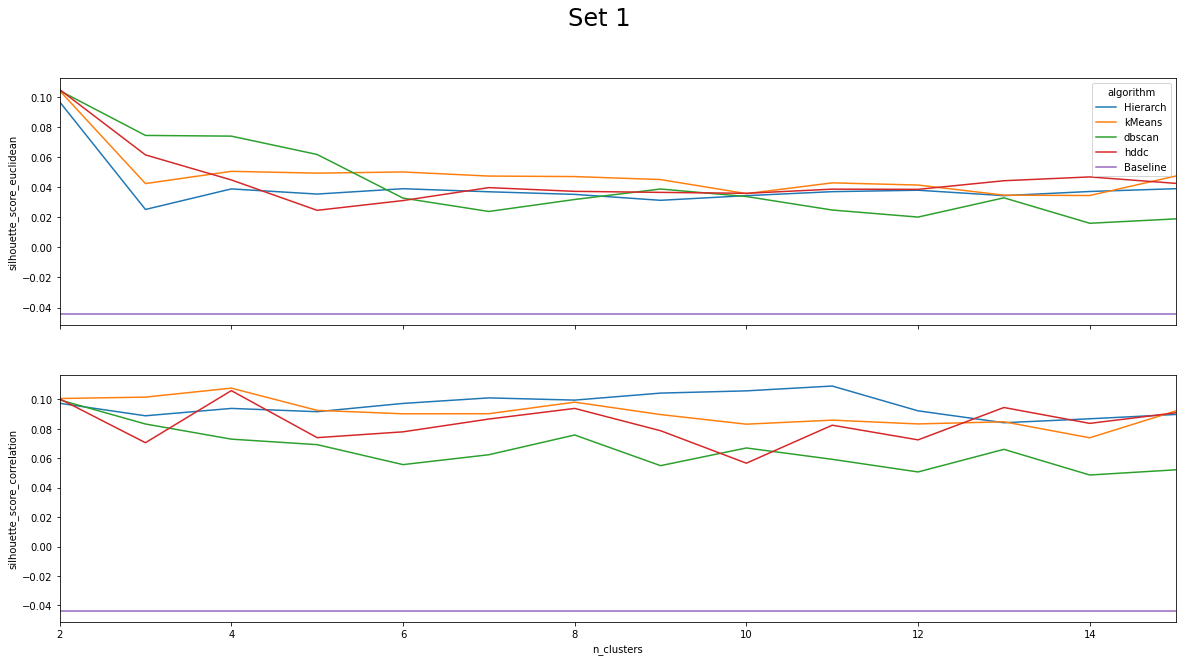

In [8]:
i = 1
with open(f'/home/g0017139/UMCG_Thesis/Scripts/Results/TSet{i}/Merged_results.pkl', 'rb') as f:
    results_grid = pickle.load(f)
end_df = get_results_plot(results_grid, i)

Scores are everywhere better than the baseline. Highest Euclidian score for 2 clusers after that it drops of. Correlation score stays similair

### Best parameters for every algorithm:

In [9]:
top_df = get_individual_score(results_grid, i)

_________________________________________Hierarch_________________________________________

                        -----------------mean------------------
    n_clusters  silhouette_score_euclidean  silhouette_score_correlation
13           2                    0.096876                      0.097234
5           11                    0.037080                      0.108922
6           10                    0.034417                      0.105647

_________________________________________kMeans_________________________________________

                        -----------------mean------------------
   silhouette_score_euclidean  silhouette_score_correlation  n_clusters  batch_size
2                    0.104322                      0.099542           2         512
3                    0.104322                      0.099542           2        1024
1                    0.104322                      0.099542           2         256

_________________________________________dbscan_____________

### Which parameters were the best for HDDC? (Best clusters is two clusters)

In [10]:
with open(f'/home/g0017139/UMCG_Thesis/Scripts/Results/TSet{i}/Merged_GridHDDC.pkl', 'rb') as f:
    grid = pickle.load(f)
grid[grid['K']==2]

,model,K,threshold,LL,BIC,ICL,rank,complexity
168,12.0,2.0,0.01,-2.344247e+07,-5.304252e+07,-5.304252e+07,1,883109.0
169,8.0,2.0,0.01,-2.344605e+07,-5.304939e+07,-5.304939e+07,2,883068.0
170,14.0,2.0,0.01,-2.347949e+07,-5.311654e+07,-5.311654e+07,3,883108.0
171,10.0,2.0,0.01,-2.348307e+07,-5.312342e+07,-5.312342e+07,4,883067.0
172,5.0,2.0,0.01,-2.348385e+07,-5.312496e+07,-5.312496e+07,5,883066.0
173,12.0,2.0,0.10,-2.592310e+07,-5.376267e+07,-5.376267e+07,9,274856.0
174,2.0,2.0,0.10,-2.592383e+07,-5.376405e+07,-5.376405e+07,10,274845.0
175,11.0,2.0,0.01,-2.298292e+07,-5.390122e+07,-5.390122e+07,12,1138078.0
176,13.0,2.0,0.01,-2.298633e+07,-5.390802e+07,-5.390802e+07,13,1138077.0
177,1.0,2.0,0.01,-2.298782e+07,-5.391063e+07,-5.391063e+07,14,1138023.0


### Save the best scores for later

In [11]:
top_performers = top_df

# The results of the gridsearch on GPL570

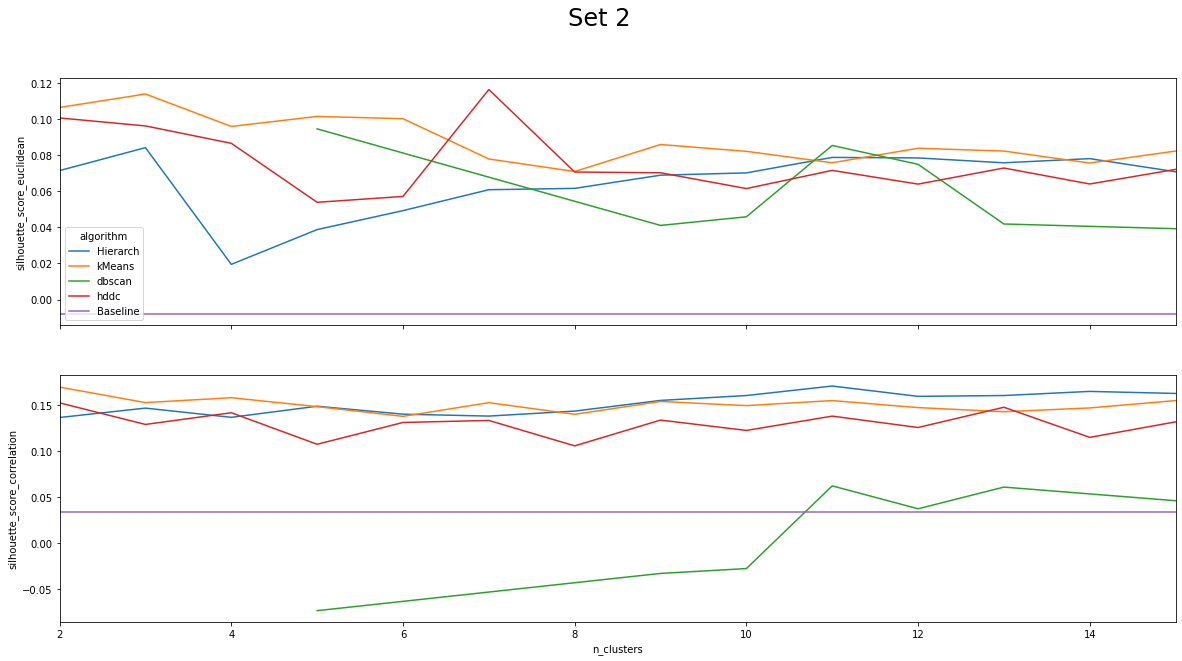

In [12]:
i = 2
with open(f'/home/g0017139/UMCG_Thesis/Scripts/Results/TSet{i}/Merged_results.pkl', 'rb') as f:
    results_grid = pickle.load(f)
end_df = get_results_plot(results_grid, i,15)

Scores are everywhere better than the baseline except for hdbscan for correlation. Highest Euclidian score for 2 or 7 clusers. Correlation score stays similair except for dbdcan this shows a massive uptake.

### Best parameters for every algorithm:

In [13]:
top_df = get_individual_score(results_grid, i)

_________________________________________Hierarch_________________________________________

                        -----------------mean------------------
   n_clusters  silhouette_score_euclidean  silhouette_score_correlation
5          11                    0.078743                      0.170815
7          14                    0.078069                      0.164967
4          12                    0.078446                      0.159587

_________________________________________kMeans_________________________________________

                        -----------------mean------------------
   silhouette_score_euclidean  silhouette_score_correlation  n_clusters  batch_size
2                    0.106415                      0.168410           2         512
0                    0.104697                      0.167795           2         128
1                    0.099814                      0.169664           2         256

_________________________________________dbscan_________________

### Which parameters were the best for HDDC? (Best clusters is two clusters)

In [14]:
with open(f'/home/g0017139/UMCG_Thesis/Scripts/Results/TSet{i}/Merged_GridHDDC.pkl', 'rb') as f:
    grid = pickle.load(f)
grid[grid['K']==2]

,model,K,threshold,LL,BIC,ICL,rank,complexity
12,1.0,2.0,0.01,-3.997821e+08,-8.073990e+08,-8.073990e+08,15,785054.0
13,1.0,2.0,0.10,-4.816348e+08,-9.656210e+08,-9.656210e+08,38,235604.0
14,1.0,2.0,0.20,-5.189532e+08,-1.039278e+09,-1.039278e+09,42,137446.0


### Save for later use

In [15]:
top_performers = pd.concat([top_performers, top_df])

# The results of the gridsearch on TCGA

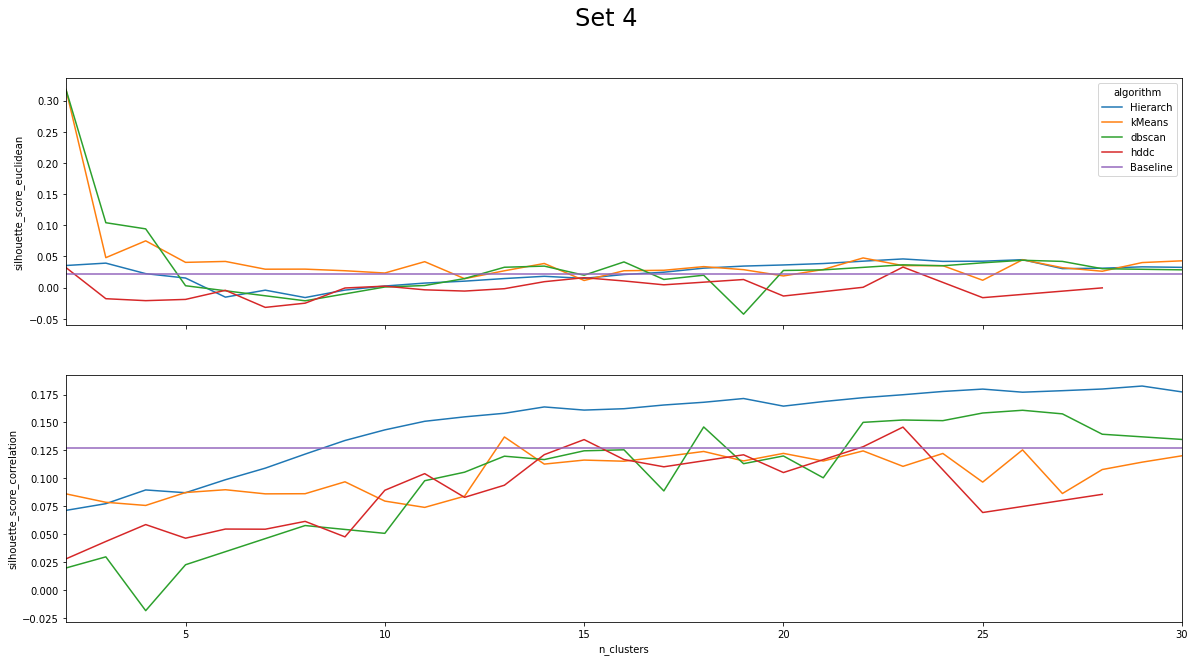

In [16]:
i = 4
with open(f'/home/g0017139/UMCG_Thesis/Scripts/Results/TSet{i}/Merged_results.pkl', 'rb') as f:
    results_grid = pickle.load(f)
end_df = get_results_plot(results_grid, i, 30)

Scores are mostly the same as the baseline. Euclidan score stays quite constant with the best score at 2 clusters. Correlation score goes up the more clusters there are made

### Best parameters for every algorithm:

In [17]:
top_df = get_individual_score(results_grid, i)

_________________________________________Hierarch_________________________________________

                        -----------------mean------------------
    n_clusters  silhouette_score_euclidean  silhouette_score_correlation
14          26                    0.044681                      0.177098
3           23                    0.045890                      0.174826
24          25                    0.042254                      0.179879

_________________________________________kMeans_________________________________________

                        -----------------mean------------------
    silhouette_score_euclidean  silhouette_score_correlation  n_clusters  batch_size
46                    0.017081                      0.136988          13         512
99                    0.044580                      0.125394          26        1024
82                    0.047497                      0.124477          22         512

_________________________________________dbscan_________

### Which parameters were the best for HDDC? (Best clusters is 19 clusters)

In [18]:
with open(f'/home/g0017139/UMCG_Thesis/Scripts/Results/TSet4/Merged_GridHDDC.pkl', 'rb') as f:
    grid = pickle.load(f)
grid[grid['K']==19]

,model,K,threshold,LL,BIC,ICL,rank,complexity,comment
129,1.0,19.0,0.01,-1.893872e+08,-4.565809e+08,-4.565809e+08,57,8376323.0,0
130,1.0,19.0,0.2,-2.260699e+08,-4.707020e+08,-4.707020e+08,113,1998323.0,0


In [19]:
top_performers = pd.concat([top_performers, top_df])

# Compare the best results of every algorithm on every set

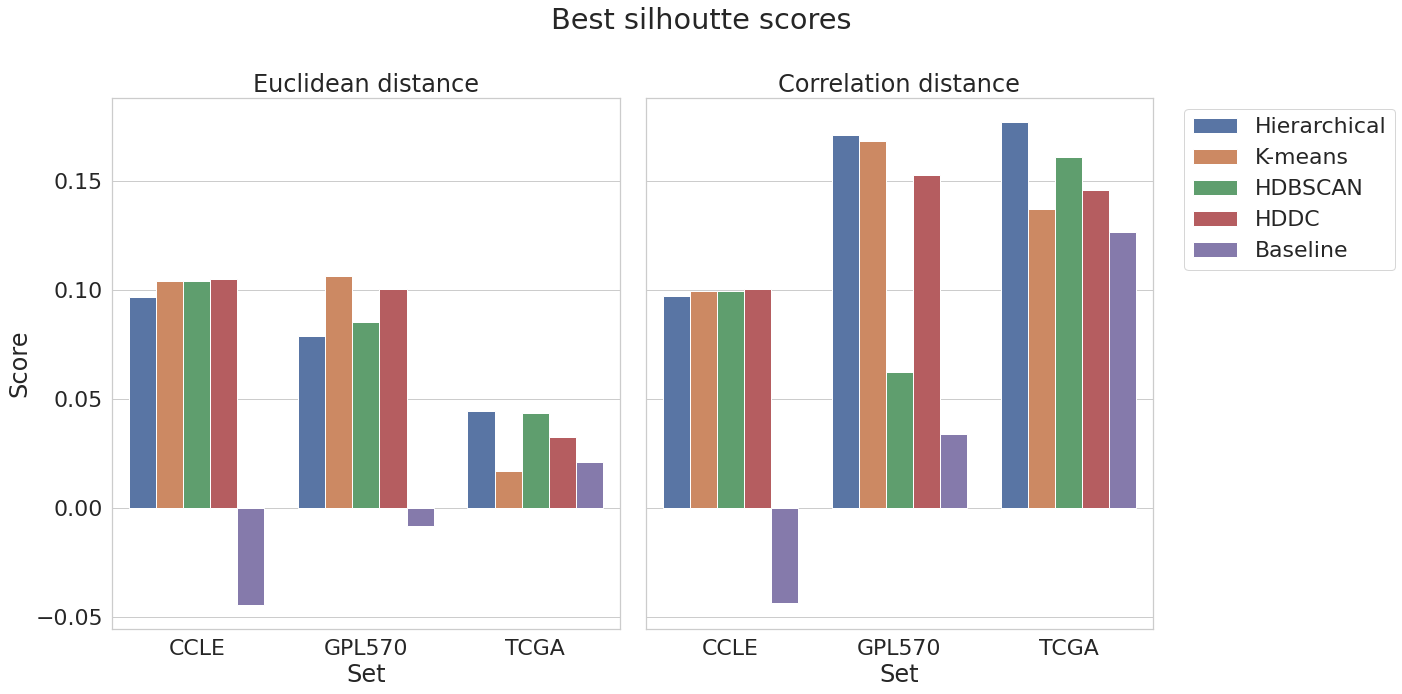

In [32]:
import seaborn as sns
# top_performers['Algorithm'] = top_performers['Algorithm'].str.replace('Hierarch', 'Hierarchical')
# top_performers['Algorithm'] = top_performers['Algorithm'].str.replace('kMeans', 'K-means')
# top_performers['Algorithm'] = top_performers['Algorithm'].str.replace('dbscan', 'HDBSCAN')
# top_performers['Algorithm'] = top_performers['Algorithm'].str.replace('hddc', 'HDDC')
sns.set(font_scale = 2,style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10), sharey=True)

sns.barplot(x="Set", y="silhouette_score_euclidean", hue="Algorithm", data=top_performers, ax=ax1)
sns.barplot(x="Set", y="silhouette_score_correlation", hue="Algorithm", data=top_performers, ax=ax2)

ax1.get_legend().remove()
ax1.set_title('Euclidean distance')
ax2.set_title('Correlation distance')
ax1.set_ylabel("Score")
ax2.set_ylabel("")
ax2.legend(bbox_to_anchor=(1.04,1), loc="upper left")
fig.suptitle('Best silhoutte scores')
plt.tight_layout()
plt.savefig('Best_Scores.svg', dpi=300)

# Make example heatmap

In [21]:
def heatmap(df):
    tabs = []
    # Loop over every cluster type
    for column in df:
        if column == '2':
            start_df = df.copy()
            start_df['count'] = 1
            # Count how often every cluster type appears
            count_df = start_df.groupby([column, 'Type']).sum().reset_index()
            sum_df = start_df.groupby(['Type']).sum()
            new_col = []
            for index, row in count_df.iterrows():
                new_col.append(sum_df.loc[row['Type'],:]['count'])
            # Take the relative counts
            count_df['Percentage'] = count_df['count'] / new_col
            count_df = count_df.drop('count', axis=1)
            # Pivot it to make it correct input for seaborn
            data = pd.pivot_table(count_df, values='Percentage', index='Type', columns=column, fill_value=0)
            # Make the clustermap from seaborn
            fig = sns.clustermap(data, method="ward", col_cluster=False,  cmap="YlGnBu", figsize=(10,10))
            plt.savefig('TEMPDELETE.png', dpi=1200)
    # Return all the seperate tabs
    #fig = pn.Tabs(*tabs)
    return fig

In [22]:
import sys
sys.path.append("..")
from Commen_Functions import get_score, get_score_df, merge_Results, load_sets
clusters = pd.read_pickle("/home/g0017139/UMCG_Thesis/Scripts/Results/TSet1/MergedClustersHDDC.pkl")
df, df_normalized, Type_df = load_sets(1)

In [23]:
clusters['Type'] = df['TYPE'].values

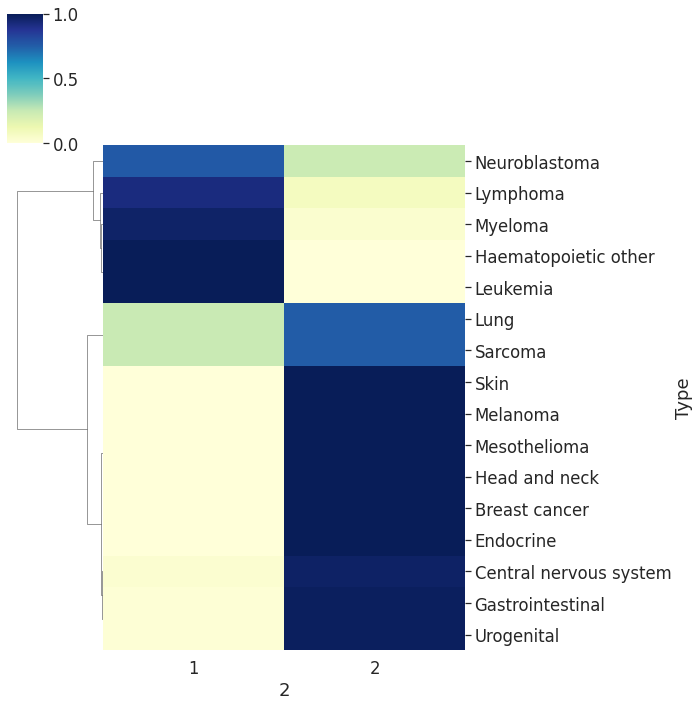

In [24]:
sns.set(font_scale = 1.5,style="whitegrid")
heatmap(clusters)